# Experiment 3

- Multiple Parameters (5x3) => 15 model runs
- **no** market pressure as the initial prices are proportional to trade sizes
- 5 LPs providing entirety of respective tokens (1-5) each
- one trader executing random actions with probabilities:
    - 'sell_r2_for_r1': 0.5,
    - 'sell_r1_for_r2': 0,
    - 'sell_r4_for_r3': 0.25,
    - 'sell_r3_for_r4': 0.25
- asset 5 is not affected by trader's actions

In [18]:
from model.model_initialization import * 
initialize_model([1000000, 1500000, 2000000, 2500000, 3000000], 100, 0.01, 0.00)

{'cfmm_type': '',
 'initial_values': {'token_list': ['R1', 'R2', 'R3', 'R4', 'R5'],
  'R': [1000000, 1500000, 2000000, 2500000, 3000000],
  'P': [2, 0.6666666666666666, 1, 3, 4],
  'fee_assets': 0.01,
  'fee_HDX': 0.0},
 'agent_d': {'Trader': {'HDX': 1000000,
   'R1': 1000000,
   'R2': 1000000,
   'R3': 1000000,
   'R4': 1000000,
   'R5': 1000000},
  'LP1': {'omniR1': 1000000},
  'LP2': {'omniR2': 1500000},
  'LP3': {'omniR3': 2000000},
  'LP4': {'omniR4': 2500000},
  'LP5': {'omniR5': 3000000}},
 'action_ls': [('trade', 1000)],
 'prob_dict': {'trade': {'sell_r2_for_r1': 0.5,
   'sell_r1_for_r2': 0,
   'sell_r4_for_r3': 0.25,
   'sell_r3_for_r4': 0.25}},
 'action_dict': {'sell_r2_for_r1': {'token_buy': 'R1',
   'token_sell': 'R2',
   'amount_sell': 300,
   'action_id': 'Trade',
   'agent_id': 'Trader'},
  'sell_r1_for_r2': {'token_sell': 'R1',
   'token_buy': 'R2',
   'amount_sell': 100,
   'action_id': 'Trade',
   'agent_id': 'Trader'},
  'sell_r4_for_r3': {'token_buy': 'R3',
   'toke

In [2]:
#########################################################
#           import of packages & dependencies
#########################################################
import pandas as pd

from IPython.core.debugger import Pdb
ipdb = Pdb()

from model import init_utils
from model import processing
# Experiments
from model import run
from model.plot_utils import *
from model.model_initialization import * 

import numpy as np
import seaborn as sns
import matplotlib.pylab as plt


#########################################################
#     setting of experiment variables & parameters
#########################################################


fee_level_assets = (0.00, 0.01, 0.02, 0.03, 0.04)
#fee_level_assets = (0.00, 0.01)
fee_level_hdx = 0.00
# uniform_data = np.random.rand(10, 12)
#trade_volume = {'10': 0.5, '20': 0.6}
#liquidity = {'1000': 0.5, '2000': 0.6}
#trade_volume = (50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000)
#liquidity = (100000, 200000, 300000, 400000, 500000, 600000, 700000, 800000)
trade_volume = [100, 110, 120]
#trade_volume = [100, 120]
liquidity_providers = [1000000, 1500000, 2000000, 2500000, 3000000]
sim_nr = 0

#########################################################
#     specification of agent (for non-hard-coded calculations)
#########################################################

performance_of_agent = 'LP3'


if performance_of_agent == 'LP1':
    asset_of_agent = 'omniR1'
elif performance_of_agent == 'LP2':
    asset_of_agent = 'omniR2'
elif performance_of_agent == 'LP3':
    asset_of_agent = 'omniR3'

#########################################################
#     preparation of empty result matrix
#########################################################

m=len(trade_volume)
n=len(fee_level_assets)
matrix = np.ndarray(shape = (m,n), dtype = int)
matrix1 = np.ndarray(shape = (m,n), dtype = int)
matrix2 = np.ndarray(shape = (m,n), dtype = int)
matrix3 = np.ndarray(shape = (m,n), dtype = int)
matrix4 = np.ndarray(shape = (m,n), dtype = int)
matrix5 = np.ndarray(shape = (m,n), dtype = int)
matrix_ror = np.ndarray(shape = (m,n), dtype = int)
matrix_ror1 = np.ndarray(shape = (m,n), dtype = int)
matrix_ror2 = np.ndarray(shape = (m,n), dtype = int)
matrix_ror3 = np.ndarray(shape = (m,n), dtype = int)
matrix_ror4 = np.ndarray(shape = (m,n), dtype = int)
matrix_ror5 = np.ndarray(shape = (m,n), dtype = int)


#########################################################
#     repeated simulation runs with above parameters
#########################################################


for i in range(len(fee_level_assets)):
    for j in range(len(trade_volume)):
        #########################################################
        # initialize model with starting conditions for each run
        #########################################################
        
        config_params = initialize_model(liquidity_providers, trade_volume[j], fee_level_assets[i], fee_level_hdx)
        
        #########################################################
        # run model with above initialization
        #########################################################
        
        config_dict, state = init_utils.get_configuration(config_params)

        pd.options.mode.chained_assignment = None  # default='warn'
        pd.options.display.float_format = '{:.2f}'.format
        
        run.config(config_dict, state)
        events = run.run()
        
        rdf, agent_df = processing.postprocessing(events)

        #########################################################
        # calculate profitability metrics; change in pool values
        #########################################################
        
         
        print(sim_nr)
        total_timesteps = config_params.get('action_ls')[0][1] #grabbing the same total timestep as through initialize_model
        #total_timesteps = 1000
        first_timestep = 1
        print(total_timesteps)
        
        ## merge agent and pool dataframes
        profit_results = pd.merge(agent_df, rdf, how="inner", on=["timestep", "simulation", "run", "subset", "substep"])
        
        ## assign additional columns
        profit_results['val_pool'] = profit_results.apply(lambda x: processing.val_pool(x), axis=1)
        initial_values = config_params['initial_values']
        agent_d = config_params['agent_d']
        withdraw_agent_d = processing.get_withdraw_agent_d(initial_values, agent_d)
        print(withdraw_agent_d)
        profit_results['val_hold'] = profit_results.apply(lambda x: processing.val_hold(x, withdraw_agent_d), axis=1)
        #profit_results['IL'] = profit_results.apply(lambda x: x['val_pool']/x['val_hold'] - 1, axis=1)
        profit_results['pool_val'] = profit_results.apply(lambda x: processing.pool_val(x), axis=1)
        
        ## calculate profits from 'val_pool' for initialized agent     
        profit_results1 = profit_results[profit_results['simulation'] == sim_nr]
        profit_results2 = profit_results1[profit_results1['timestep'] == total_timesteps]
        profit_results3 = profit_results1[profit_results1['timestep'] == first_timestep]
        profit_results4 = profit_results2[profit_results2['agent_label'] == performance_of_agent] #define selection for final timestep for desired agent (LP1 / LP2 / ??)
        profit_results5 = profit_results3[profit_results3['agent_label'] == performance_of_agent] #define selection for first timestep for desired agent (LP1 / LP2 / ??)
 
        ## calculate profits from 'val_pool' for hardcored agents (workaround)
        profit_results41 = profit_results2[profit_results2['agent_label'] == 'LP1']
        profit_results51 = profit_results3[profit_results3['agent_label'] == 'LP1']
        profit_results42 = profit_results2[profit_results2['agent_label'] == 'LP2']
        profit_results52 = profit_results3[profit_results3['agent_label'] == 'LP2']
        profit_results43 = profit_results2[profit_results2['agent_label'] == 'LP3']
        profit_results53 = profit_results3[profit_results3['agent_label'] == 'LP3']
        profit_results44 = profit_results2[profit_results2['agent_label'] == 'LP4']
        profit_results54 = profit_results3[profit_results3['agent_label'] == 'LP4']
        profit_results45 = profit_results2[profit_results2['agent_label'] == 'LP5']
        profit_results55 = profit_results3[profit_results3['agent_label'] == 'LP5']
        
        profit_sim0 = profit_results4['val_pool'].iloc[0] - profit_results5['val_pool'].iloc[0] # 
        profit_sim1 = profit_results41['val_pool'].iloc[0] - profit_results51['val_pool'].iloc[0] # profit for LP1
        profit_sim2 = profit_results42['val_pool'].iloc[0] - profit_results52['val_pool'].iloc[0] # profit for LP2
        profit_sim3 = profit_results43['val_pool'].iloc[0] - profit_results53['val_pool'].iloc[0] # profit for LP3
        profit_sim4 = profit_results44['val_pool'].iloc[0] - profit_results54['val_pool'].iloc[0] # profit for LP2
        profit_sim5 = profit_results45['val_pool'].iloc[0] - profit_results55['val_pool'].iloc[0] # profit for LP3
        
        ## calculate 'rate of return' in basispoints
        ror0 = (profit_sim0 / agent_d[performance_of_agent][asset_of_agent]) * 10000
        ror1 = (profit_sim1 / agent_d['LP1']['omniR1']) * 10000 # RoR for LP1 in bp
        ror2 = (profit_sim2 / agent_d['LP2']['omniR2']) * 10000 # RoR for LP2 in bp
        ror3 = (profit_sim3 / agent_d['LP3']['omniR3']) * 10000 # RoR for LP3 in bp
        ror4 = (profit_sim4 / agent_d['LP4']['omniR4']) * 10000 # RoR for LP4 in bp
        ror5 = (profit_sim5 / agent_d['LP5']['omniR5']) * 10000 # RoR for LP5 in bp
                    
        #########################################################
        # assign metrics (profit, ror) to empty matrix
        #########################################################
        
        #matrix[j][i] = np.random.randint(1, 100 + 1)
        #matrix[j][i] = trade_volume[i]*liquidity[j]
        matrix[j][i] = profit_sim0
        matrix1[j][i] = profit_sim1
        matrix2[j][i] = profit_sim2
        matrix3[j][i] = profit_sim3
        matrix4[j][i] = profit_sim4
        matrix5[j][i] = profit_sim5
        #matrix1[j][i] = profit_sim1
        matrix_ror[j][i] = ror0
        matrix_ror1[j][i] = ror1
        matrix_ror2[j][i] = ror2
        matrix_ror3[j][i] = ror3
        matrix_ror4[j][i] = ror4
        matrix_ror5[j][i] = ror5
        #matrix_ror1[j][i] = ror1
        
        #########################################################
        ## increase simulation count
        #########################################################
        
        sim_nr += 1




                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (1000, 3, 1, 3)
Execution Method: local_simulations
SimIDs   : [0]
SubsetIDs: [0]
Ns       : [0]
ExpIDs   : [0]
Execution Mode: single_threaded
Total execution time: 1.61s
0
1000
{'Trader': {'q': 1000000, 's': [0, 0, 0, 0, 0], 'r': [1000000, 1000000, 1000000, 1000000, 1000000], 'p': [0, 0, 0, 0, 0]}, 'LP1': {'q': 0.0, 's': [0, 0, 0, 0, 0], 'r': [1000000.0, 0, 0, 0, 0], 'p': [2.0, 0, 0, 0, 0]}, 'LP2': {'q': 0.0, 's': [0, 0, 0, 0, 0], 'r': [0, 1500000.0, 0, 0, 0], 'p': [0, 0.6666666666666666, 0, 0, 0]}, 'LP3': {'q': 0.0, 's': [0, 0, 0, 0, 0], 'r': [0, 0, 2000000.0, 0, 0], 'p': [0, 0, 1.0, 0, 0]}, 'LP4': {'q': 0.0, 's': [0, 0, 0, 0, 0], 'r': [0, 0, 0, 2500000.0, 0], 'p': 

Total execution time: 43.34s
7
1000
{'Trader': {'q': 1000000, 's': [0, 0, 0, 0, 0], 'r': [1000000, 1000000, 1000000, 1000000, 1000000], 'p': [0, 0, 0, 0, 0]}, 'LP1': {'q': 0.0, 's': [0, 0, 0, 0, 0], 'r': [1000000.0, 0, 0, 0, 0], 'p': [2.0, 0, 0, 0, 0]}, 'LP2': {'q': 0.0, 's': [0, 0, 0, 0, 0], 'r': [0, 1500000.0, 0, 0, 0], 'p': [0, 0.6666666666666666, 0, 0, 0]}, 'LP3': {'q': 0.0, 's': [0, 0, 0, 0, 0], 'r': [0, 0, 2000000.0, 0, 0], 'p': [0, 0, 1.0, 0, 0]}, 'LP4': {'q': 0.0, 's': [0, 0, 0, 0, 0], 'r': [0, 0, 0, 2500000.0, 0], 'p': [0, 0, 0, 3.0, 0]}, 'LP5': {'q': 0.0, 's': [0, 0, 0, 0, 0], 'r': [0, 0, 0, 0, 3000000.0], 'p': [0, 0, 0, 0, 4.0]}}

                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 9
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (1000, 3, 1, 3)
Execution Me

Total execution time: 22.86s
14
1000
{'Trader': {'q': 1000000, 's': [0, 0, 0, 0, 0], 'r': [1000000, 1000000, 1000000, 1000000, 1000000], 'p': [0, 0, 0, 0, 0]}, 'LP1': {'q': 0.0, 's': [0, 0, 0, 0, 0], 'r': [1000000.0, 0, 0, 0, 0], 'p': [2.0, 0, 0, 0, 0]}, 'LP2': {'q': 0.0, 's': [0, 0, 0, 0, 0], 'r': [0, 1500000.0, 0, 0, 0], 'p': [0, 0.6666666666666666, 0, 0, 0]}, 'LP3': {'q': 0.0, 's': [0, 0, 0, 0, 0], 'r': [0, 0, 2000000.0, 0, 0], 'p': [0, 0, 1.0, 0, 0]}, 'LP4': {'q': 0.0, 's': [0, 0, 0, 0, 0], 'r': [0, 0, 0, 2500000.0, 0], 'p': [0, 0, 0, 3.0, 0]}, 'LP5': {'q': 0.0, 's': [0, 0, 0, 0, 0], 'r': [0, 0, 0, 0, 3000000.0], 'p': [0, 0, 0, 0, 4.0]}}


## Results

### Absolute Returns for LPs

### Selected Agent

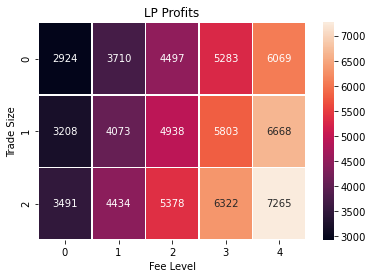

In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

#ax = sns.heatmap(uniform_data, linewidth=0.5)
ax = sns.heatmap(matrix, linewidth=0.5, annot=True, fmt="d")
ax.set_title("LP Profits")
#ax.set_title("LP Profits for fee level:" % fee_level)
ax.set_xlabel('Fee Level')
ax.set_ylabel('Trade Size')
plt.show()

### LP 1

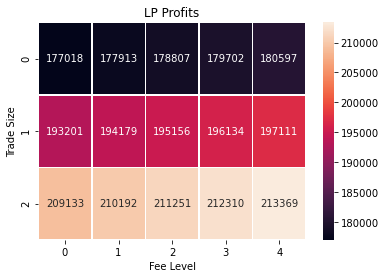

In [4]:
#ax = sns.heatmap(uniform_data, linewidth=0.5)
ax = sns.heatmap(matrix1, linewidth=0.5, annot=True, fmt="d")
ax.set_title("LP Profits")
#ax.set_title("LP Profits for fee level:" % fee_level)
ax.set_xlabel('Fee Level')
ax.set_ylabel('Trade Size')
plt.show()

### LP 2

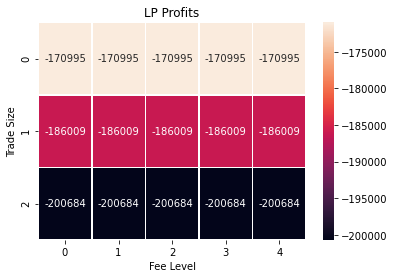

In [5]:
#ax = sns.heatmap(uniform_data, linewidth=0.5)
ax = sns.heatmap(matrix2, linewidth=0.5, annot=True, fmt="d")
ax.set_title("LP Profits")
#ax.set_title("LP Profits for fee level:" % fee_level)
ax.set_xlabel('Fee Level')
ax.set_ylabel('Trade Size')
plt.show()

### LP 3

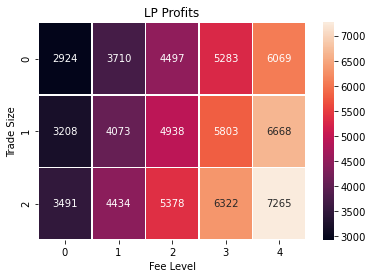

In [6]:
#ax = sns.heatmap(uniform_data, linewidth=0.5)
ax = sns.heatmap(matrix3, linewidth=0.5, annot=True, fmt="d")
ax.set_title("LP Profits")
#ax.set_title("LP Profits for fee level:" % fee_level)
ax.set_xlabel('Fee Level')
ax.set_ylabel('Trade Size')
plt.show()

### LP 4

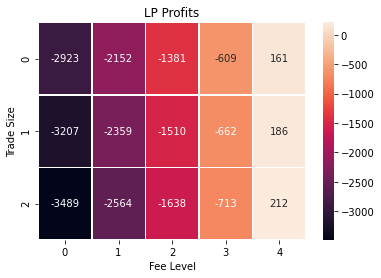

In [7]:
#ax = sns.heatmap(uniform_data, linewidth=0.5)
ax = sns.heatmap(matrix4, linewidth=0.5, annot=True, fmt="d")
ax.set_title("LP Profits")
#ax.set_title("LP Profits for fee level:" % fee_level)
ax.set_xlabel('Fee Level')
ax.set_ylabel('Trade Size')
plt.show()

### LP 5

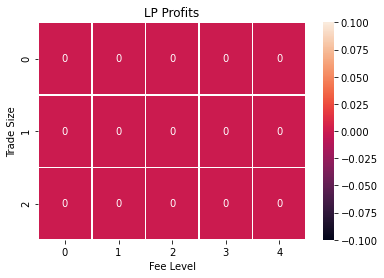

In [8]:
#ax = sns.heatmap(uniform_data, linewidth=0.5)
ax = sns.heatmap(matrix5, linewidth=0.5, annot=True, fmt="d")
ax.set_title("LP Profits")
#ax.set_title("LP Profits for fee level:" % fee_level)
ax.set_xlabel('Fee Level')
ax.set_ylabel('Trade Size')
plt.show()

## Relative Returns for LPs

In [9]:
matrix_ror

array([[14, 18, 22, 26, 30],
       [16, 20, 24, 29, 33],
       [17, 22, 26, 31, 36]])

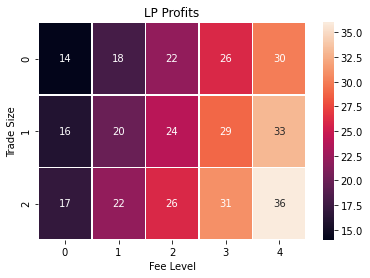

In [10]:
#ax = sns.heatmap(uniform_data, linewidth=0.5)
ax = sns.heatmap(matrix_ror, linewidth=0.5, annot=True, fmt="d")
ax.set_title("LP Profits")
#ax.set_title("LP Profits for fee level:" % fee_level)
ax.set_xlabel('Fee Level')
ax.set_ylabel('Trade Size')
plt.show()

### LP 1

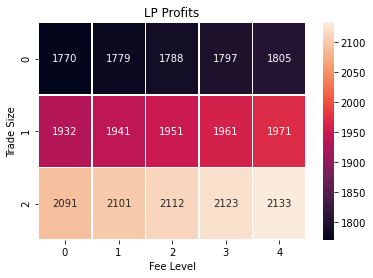

In [11]:
#ax = sns.heatmap(uniform_data, linewidth=0.5)
ax = sns.heatmap(matrix_ror1, linewidth=0.5, annot=True, fmt="d")
ax.set_title("LP Profits")
#ax.set_title("LP Profits for fee level:" % fee_level)
ax.set_xlabel('Fee Level')
ax.set_ylabel('Trade Size')
plt.show()

### LP 2

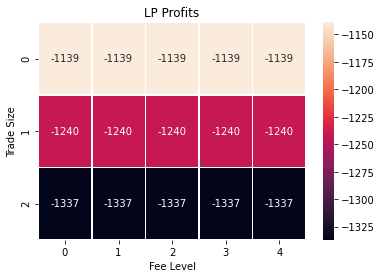

In [12]:
#ax = sns.heatmap(uniform_data, linewidth=0.5)
ax = sns.heatmap(matrix_ror2, linewidth=0.5, annot=True, fmt="d")
ax.set_title("LP Profits")
#ax.set_title("LP Profits for fee level:" % fee_level)
ax.set_xlabel('Fee Level')
ax.set_ylabel('Trade Size')
plt.show()

### LP 3

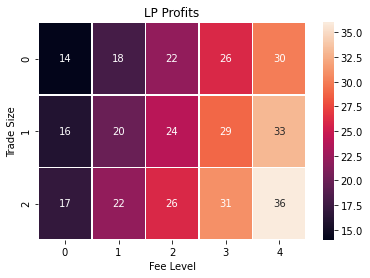

In [13]:
#ax = sns.heatmap(uniform_data, linewidth=0.5)
ax = sns.heatmap(matrix_ror3, linewidth=0.5, annot=True, fmt="d")
ax.set_title("LP Profits")
#ax.set_title("LP Profits for fee level:" % fee_level)
ax.set_xlabel('Fee Level')
ax.set_ylabel('Trade Size')
plt.show()

### LP 4

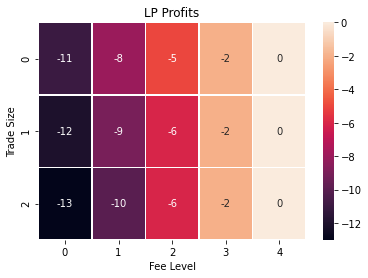

In [14]:
#ax = sns.heatmap(uniform_data, linewidth=0.5)
ax = sns.heatmap(matrix_ror4, linewidth=0.5, annot=True, fmt="d")
ax.set_title("LP Profits")
#ax.set_title("LP Profits for fee level:" % fee_level)
ax.set_xlabel('Fee Level')
ax.set_ylabel('Trade Size')
plt.show()

### LP 5

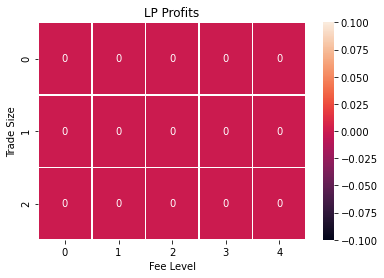

In [15]:
#ax = sns.heatmap(uniform_data, linewidth=0.5)
ax = sns.heatmap(matrix_ror5, linewidth=0.5, annot=True, fmt="d")
ax.set_title("LP Profits")
#ax.set_title("LP Profits for fee level:" % fee_level)
ax.set_xlabel('Fee Level')
ax.set_ylabel('Trade Size')
plt.show()

[0]


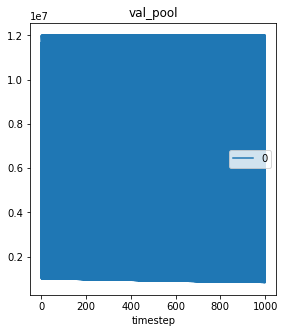

In [16]:
from model import plot_utils as pu
varlist = ['val_pool']
dataframe = profit_results[profit_results['simulation'] == 0]
pu.plot_vars(dataframe, varlist)